# Логистическая регрессия
Рассмотрим задачу *классификации*, когда нам требуется обучить алгоритм, который будет относить объект к одному из классов. В частности рассмотрим бинарную классификацию, когда имеется всего два класса, например $\{+1, -1\}$.

Линейную модель классификации можно определить так:
\begin{align*}
    a(x) = sign(x^Tw).
\end{align*}

Если имеем дело в бинарной классификацией, описанной выше, можем ввести понятие *отступа* (margin) в следующем виде:
\begin{align*}
    M_i = y_i f(x_i) = y_ix_i^Tw,
\end{align*}
где $y_i-$ ответ для $i$-го объекта. Если алгоритм правильно классифицирует объект, то отступ равен $1$, иначе $-1$.

Как и раньше, необходимо решить, какую функцию потерь будем минимизировать. Самый простой вариант - пороговая функция потерь:
\begin{align*}
    L_i = [y_i^{true} \neq y_i^{pred}] = [M_i \leq 0].
\end{align*}
Но это функция негладкая, поэтому с ней будут проблемы при нахождении минимума. Для решения этой проблемы обычно берут гладкий функционал, который аппроксимирует исходный.

<center><img src="loss_func.png" alt="drawing" width="700"/></center>

Для логистической регрессии функция потерь имеет следующий вид:
\begin{align*}
    L = \frac{1}{n}\sum\limits_{i=1}^n log\left[1+exp(-M_i) \right].
\end{align*}

В нашем примере рассмотрим выборку с двумя признаками. Тогда:
\begin{align*}
    L = \frac{1}{n}\sum\limits_{i=1}^n log\left[1+e^{-y_i(w_1x_{i1}+w_2 x_{i2})} \right].
\end{align*}
Если добавить $L2$ регуляризацию (помогает избежать переобучения):
\begin{align*}
    L = \frac{1}{n}\sum\limits_{i=1}^n log\left[1+e^{-y_i(w_1x_{i1}+w_2 x_{i2})} \right] + \frac{1}{2}C||w||^2.
\end{align*}

При решении оптимизационной задачи будем пользоваться методом градиентного спуска. Для этого нам понадобятся выражения для производных функции потерь по параметрам $w_1$ и $w_2$:
\begin{align*}
    w_1^{(k+1)}=w_1^{(k)}+\lambda\frac{1}{n}\sum\limits_{i=1}^n y_ix_{i1}\left(1-\sigma(M_i)\right) - \lambda C w_1,
\end{align*}

\begin{align*}
    w_2^{(k+1)}=w_2^{(k)}+\lambda\frac{1}{n}\sum\limits_{i=1}^n y_ix_{i2}\left(1-\sigma(M_i)\right) - \lambda C w_2,
\end{align*}
где функция $\sigma(x) = \frac{1}{1+e^{-x}}$ - *сигмоида* (sigmoid function).

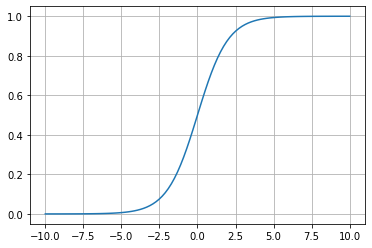

In [1]:
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(-10, 10, 100)
sigm = lambda x: 1/(1+np.exp(-x))

plt.plot(x, sigm(x))
plt.grid()

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

col_names = ['Target_variable', 'x_1', 'x_2']
df = pd.read_csv('data-logistic.csv', names=col_names)
# целевая переменная
y = df['Target_variable']
# объекты-признаки
X = df.loc[:, df.columns != 'Target_variable']

In [3]:
def grad_descent(X, y, init_vec, c_regul):
    """
    Function for gradient descent alrorithm for logistic regression
    """
    def sigmoid_func(x):
        return 1/(1+np.exp(-x))
    
    # Темп обучения
    lr = 0.1
    # Точность
    tol = 1e-5
    # Максимальное кол-во итераций
    max_iter = 1e4
    w_1 = init_vec[0]; w_2 = init_vec[1]
    num_elem = len(X)
    num_iter = 0
    while num_iter < max_iter:
        num_iter += 1
        w_1_new = w_1 - lr*c_regul*w_1 \
            + lr/num_elem*np.sum(y*X['x_1']*(1-sigmoid_func(y*(w_1*X['x_1']+w_2*X['x_2']))))
        w_2_new = w_2 - lr*c_regul*w_2 \
            + lr/num_elem*np.sum(y*X['x_2']*(1-sigmoid_func(y*(w_1*X['x_1']+w_2*X['x_2']))))
        if (np.linalg.norm(w_1_new-w_1) <= tol) or (np.linalg.norm(w_2_new-w_2) <= tol):
            w_1 = w_1_new
            w_2 = w_2_new
            break 
        w_1 = w_1_new
        w_2 = w_2_new

    return w_1, w_2

In [4]:
# Параметр регуляризации (C=0, если нет регуляризации)
c_regul = 1
# Начальный вектор
init_vec = [0, 0]
# Найдем параметр без и с регуляризацией
w_1_reg, w_2_reg = grad_descent(X, y, init_vec, c_regul)
w_1_noreg, w_2_noreg = grad_descent(X, y, init_vec, 0)
# Найдем условные вероятности принадлежности к классу
probs_reg = 1/(1+np.exp(-w_1_reg*X['x_1']-w_2_reg*X['x_2']))
probs_noreg = 1/(1+np.exp(-w_1_noreg*X['x_1']-w_2_noreg*X['x_2']))

Пояснение к поледнему выражению: вероятность принадлежности объекта к классу "+1" равна $p=\sigma \left(x^T w \right)$

In [5]:
# Оценим качество с помощью метрики AUC-ROC
roc_reg = roc_auc_score(y, probs_reg)
roc_noreg = roc_auc_score(y, probs_noreg)

In [6]:
print(roc_reg, roc_noreg)

0.9369523809523809 0.9268571428571428
